In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):
    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([-0.824683  , -0.5655952 , -0.41859964], dtype=float32)

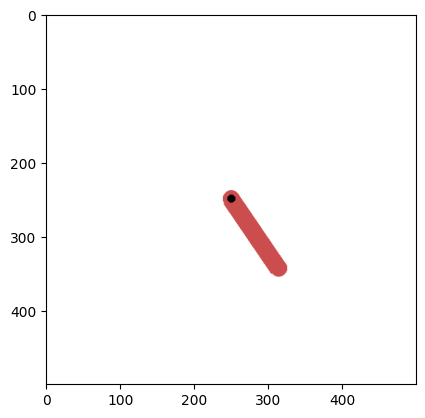

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
import torch

#计算动作的模型,也是真正要用的模型
model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

#经验网络,用于评估一个状态的分数
next_model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

#把model的参数复制给next_model
next_model.load_state_dict(model.state_dict())

model, next_model

(Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ))

In [4]:
import random


def get_action(state):
    #走神经网络,得到一个动作
    state = torch.FloatTensor(state).reshape(1, 3)
    action = model(state).argmax().item()

    if random.random() < 0.01:
        action = random.choice(range(11))

    #离散动作连续化
    action_continuous = action
    action_continuous /= 10
    action_continuous *= 4
    action_continuous -= 2

    return action, action_continuous


get_action([0.29292667, 0.9561349, 1.0957013])

(7, 0.7999999999999998)

In [5]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action, action_continuous = get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step([action_continuous])

            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 5000, 0)

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 5000:
        datas.pop(0)

    return update_count, drop_count


update_data(), len(datas)

((200, 0), 200)

In [6]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state, action, reward, next_state, over

/tmp/ipykernel_1387/1416897299.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)


(tensor([[-9.8579e-01, -1.6799e-01,  3.3351e-01],
         [-9.7823e-01, -2.0754e-01,  1.4936e-01],
         [-9.7952e-01, -2.0136e-01, -2.7487e-01],
         [-9.3178e-01, -3.6301e-01, -2.5567e-01],
         [-9.8903e-01, -1.4770e-01,  3.8444e-01],
         [-9.7384e-01, -2.2724e-01,  2.2905e-01],
         [-9.7185e-01, -2.3560e-01,  7.3057e-03],
         [-9.9049e-01, -1.3762e-01, -3.2882e-01],
         [-9.6954e-01, -2.4493e-01,  1.2423e-02],
         [-9.6923e-01, -2.4616e-01,  2.3374e-01],
         [-9.9466e-01, -1.0322e-01, -2.7013e-01],
         [-9.9753e-01, -7.0183e-02,  1.4830e-01],
         [-9.7093e-01, -2.3936e-01, -9.0146e-02],
         [-9.9604e-01, -8.8886e-02, -1.3484e-01],
         [-9.9184e-01, -1.2750e-01,  1.7671e-01],
         [-9.9550e-01, -9.4765e-02, -3.8438e-01],
         [-9.8710e-01, -1.6010e-01, -3.9193e-01],
         [-9.9130e-01, -1.3166e-01, -3.2390e-01],
         [-9.9159e-01, -1.2943e-01,  2.9866e-01],
         [-9.5721e-01, -2.8938e-01, -6.0452e-01],


In [7]:
def get_value(state, action):
    #使用状态计算出动作的logits
    #[b, 3] -> [b, 11]
    value = model(state)

    #根据实际使用的action取出每一个值
    #这个值就是模型评估的在该状态下,执行动作的分数
    #在执行动作前,显然并不知道会得到的反馈和next_state
    #所以这里不能也不需要考虑next_state和reward
    #[b, 11] -> [b, 1]
    value = value.gather(dim=1, index=action)

    return value


get_value(state, action)

tensor([[0.1995],
        [0.1620],
        [0.1085],
        [0.1003],
        [0.2113],
        [0.1745],
        [0.1376],
        [0.1069],
        [0.1374],
        [0.1735],
        [0.1107],
        [0.1682],
        [0.1230],
        [0.1258],
        [0.1708],
        [0.1120],
        [0.1072],
        [0.1074],
        [0.1935],
        [0.1472],
        [0.1489],
        [0.1673],
        [0.1055],
        [0.1352],
        [0.1710],
        [0.1339],
        [0.1077],
        [0.3016],
        [0.1115],
        [0.1916],
        [0.1260],
        [0.1569],
        [0.1967],
        [0.1778],
        [0.1292],
        [0.1569],
        [0.1135],
        [0.1462],
        [0.1136],
        [0.1457],
        [0.1507],
        [0.1160],
        [0.1738],
        [0.1190],
        [0.1178],
        [0.3173],
        [0.1317],
        [0.1612],
        [0.1076],
        [0.1115],
        [0.1538],
        [0.1891],
        [0.1995],
        [0.1510],
        [0.1307],
        [0

In [8]:
def get_target(reward, next_state, over):
    #上面已经把模型认为的状态下执行动作的分数给评估出来了
    #下面使用next_state和reward计算真实的分数
    #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    #使用next_state计算下一个状态的分数
    #[b, 3] -> [b, 11]
    with torch.no_grad():
        target = next_model(next_state)
    """以下是主要的Double DQN和DQN的区别"""
    #取所有动作中分数最大的
    #[b, 11] -> [b]
    #target = target.max(dim=1)[0]

    #使用model计算下一个状态的分数
    #[b, 3] -> [b, 11]
    with torch.no_grad():
        model_target = model(next_state)

    #取分数最高的下标
    #[b, 11] -> [b, 1]
    model_target = model_target.max(dim=1)[1]
    model_target = model_target.reshape(-1, 1)

    #以这个下标取next_value当中的值
    #[b, 11] -> [b]
    target = target.gather(dim=1, index=model_target)
    """以上是主要的Double DQN和DQN的区别"""

    #下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    #如果next_state已经游戏结束,则next_state的分数是0
    #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    #[b, 1] * [b, 1] -> [b, 1]
    target *= (1 - over)

    #加上reward就是最终的分数
    #[b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_target(reward, next_state, over)

tensor([[-8.6556],
        [-8.4499],
        [-8.5408],
        [-7.5875],
        [-8.7675],
        [-8.3262],
        [-8.3058],
        [-8.9266],
        [-8.2513],
        [-8.2168],
        [-9.1265],
        [-9.2604],
        [-8.2957],
        [-9.1900],
        [-8.9151],
        [-9.1893],
        [-8.7976],
        [-8.9618],
        [-8.8867],
        [-7.9932],
        [-8.1584],
        [-8.2916],
        [-8.4645],
        [-9.3603],
        [-8.3078],
        [-9.2645],
        [-8.9843],
        [-8.0877],
        [-8.5498],
        [-8.4575],
        [-8.2819],
        [-9.3151],
        [-8.3504],
        [-8.6549],
        [-8.3273],
        [-8.2602],
        [-8.2883],
        [-9.2534],
        [-8.4088],
        [-9.3489],
        [-8.2494],
        [-9.3156],
        [-9.2179],
        [-8.3240],
        [-9.2170],
        [-9.1038],
        [-8.2634],
        [-8.1774],
        [-8.5752],
        [-9.2609],
        [-9.0577],
        [-8.4290],
        [-8.

In [9]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        _, action_continuous = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step([action_continuous])
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1660.0958465940482

In [10]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        update_count, drop_count = update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            #更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #把model的参数复制给next_model
            if (i + 1) % 50 == 0:
                next_model.load_state_dict(model.state_dict())

        if epoch % 20 == 0:
            test_result = sum([test(play=False) for _ in range(20)]) / 20
            print(epoch, len(datas), update_count, drop_count, test_result)


train()

0 400 200 0 -1471.570730773053
20 4400 200 0 -1029.2287193828015
40 5000 200 200 -1240.993090267291
60 5000 200 200 -362.71653557993653
80 5000 200 200 -752.8122188247723
100 5000 200 200 -562.2982438485376
120 5000 200 200 -329.80055173868806
140 5000 200 200 -293.0991555927233
160 5000 200 200 -939.51708431721
180 5000 200 200 -383.6340844127264


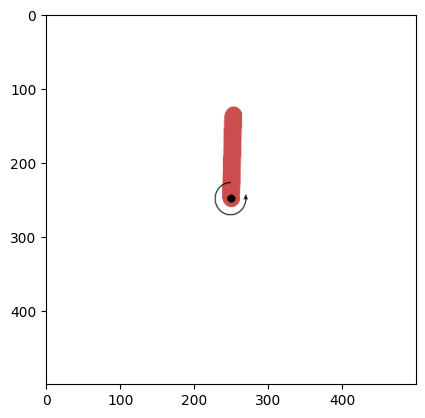

-124.75456414359867

In [11]:
test(play=True)